![logo](https://github.com/donatellacea/DL_tutorials/blob/main/notebooks/figures/1128-191-max.png?raw=true)

# XAI in deep learning-based image analysis: Feature Visualisation

---

In this first tutorial, we will see some examples of how to visualize deep learning filters (kernels) and feature maps.


### Setup Colab environment

If you installed the packages and requirements on your own machine, you can skip this section and start from the import section.
Otherwise you can follow and execute the tutorial on your browser. In order to start working on the notebook, click on the following button, this will open this page in the Colab environment and you will be able to execute the code on your own.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/HelmholtzAI-Consultants-Munich/XAI-Tutorials/blob/main/xai-model-specific/Tutorial_Feature_Visualization_CNNs.ipynb)

In [ ]:
#@markdown Now that you are visualizing the notebook in Colab:

#@markdown * Run this cell to connect your Google Drive to Colab and install packages
#@markdown * Permit this notebook to access your Google Drive files. Click on 'Yes', and select your account.
#@markdown * Google Drive for desktop wants to access your Google Account. Click on 'Allow'.
#@markdown At this point, a folder has been created in your Drive and you can navigate it through the lefthand panel in Colab, you might also have received an email that informs you about the access on your Google Drive.

from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive
!git clone https://github.com/HelmholtzAI-Consultants-Munich/XAI-Tutorials.git
%cd XAI-Tutorials/xai-model-specific/

### Import

In [1]:
# Installing the necessary packages
import torch
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import torch.nn as nn
import cv2 as cv
import argparse
from torchvision import models, transforms

## Feature visualization: theoretical part

Before starting with the hands-on part, we prepared a small video that summarizes the concepts that will be useful for the rest of the session. Take some time to watch our [Introduction to Convolutional Neural Networks and Feature Visualization](https://xai-tutorials.readthedocs.io/en/latest/_ml_basics/CNN_feature_visualization.html).

## Feature visualization: hands-on

### The model: Res-Net50

Throughout this tutorial we will be using the ResNet-50 model. Take a minute now to look at the model's architecture.

*Find out more:* [here](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=7780459) you can read the original paper for the ResNet-50 model (He, Kaiming, et al., 2016).

<div>
<img src="https://www.mdpi.com/metals/metals-11-00388/article_deploy/html/images/metals-11-00388-g004.png" width="1000" height="600"/>
</div>

Image credit: [Wang et al., 2021](https://www.mdpi.com/2075-4701/11/3/388)

Running the next cell you will:
* Load the pre-trained ImageNet weights. This will allow us to get better visualizations without training the convolutional neural network.
* Print the model, take a minute to look at its structure
* **model_weights** and **conv_layers** will save weghts of the convolutional layers and the convolutional layers' names. It is important to remember that the ResNet-50 model has 50 layers in total: 49 of those which are convolutional layers and the final is a fully connected layer.
* model.children() module, i.e. a generator that returns layers of the model from which you can extract your parameter tensors using "layername.weight" or "layername.bias" and is saved as a list.

In [2]:
# load the model
model = models.resnet50(pretrained=True)
print(model)
model_weights = [] # we will save the conv layer weights in this list
conv_layers = [] # we will save the 49 conv layers in this list
# get all the model children as list
model_children = list(model.children())

/Users/subramanian/opt/anaconda3/envs/new_xai_test/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/subramanian/opt/anaconda3/envs/new_xai_test/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

At certain stages of the model, there are nestings of Bottleneck layers within different layers. Also, the ResNet architecture has many hidden and sequential layers, so to keep only the convolutional layers we check that the two conditions below are satisfied. Then we append the child node and weights to the conv_layers and model_weights respectively.

In [3]:
# counter to keep count of the conv layers
counter = 0 
# append all the conv layers and their respective weights to the list
for i in range(len(model_children)):
    if type(model_children[i]) == nn.Conv2d:
        counter += 1
        model_weights.append(model_children[i].weight)
        conv_layers.append(model_children[i])
    elif type(model_children[i]) == nn.Sequential:
        for j in range(len(model_children[i])):
            for child in model_children[i][j].children():
                if type(child) == nn.Conv2d:
                    counter += 1
                    model_weights.append(child.weight)
                    conv_layers.append(child)
print(f"Total convolutional layers: {counter}")

Total convolutional layers: 49


### Filter visualization in the first layer

For visualizing the first conv layer filters, we are iterating through the weights of the first convolutional layer.
The output is going to be 64 filters of 7×7 dimensions. The 64 refers to the number of hidden units in that layer.

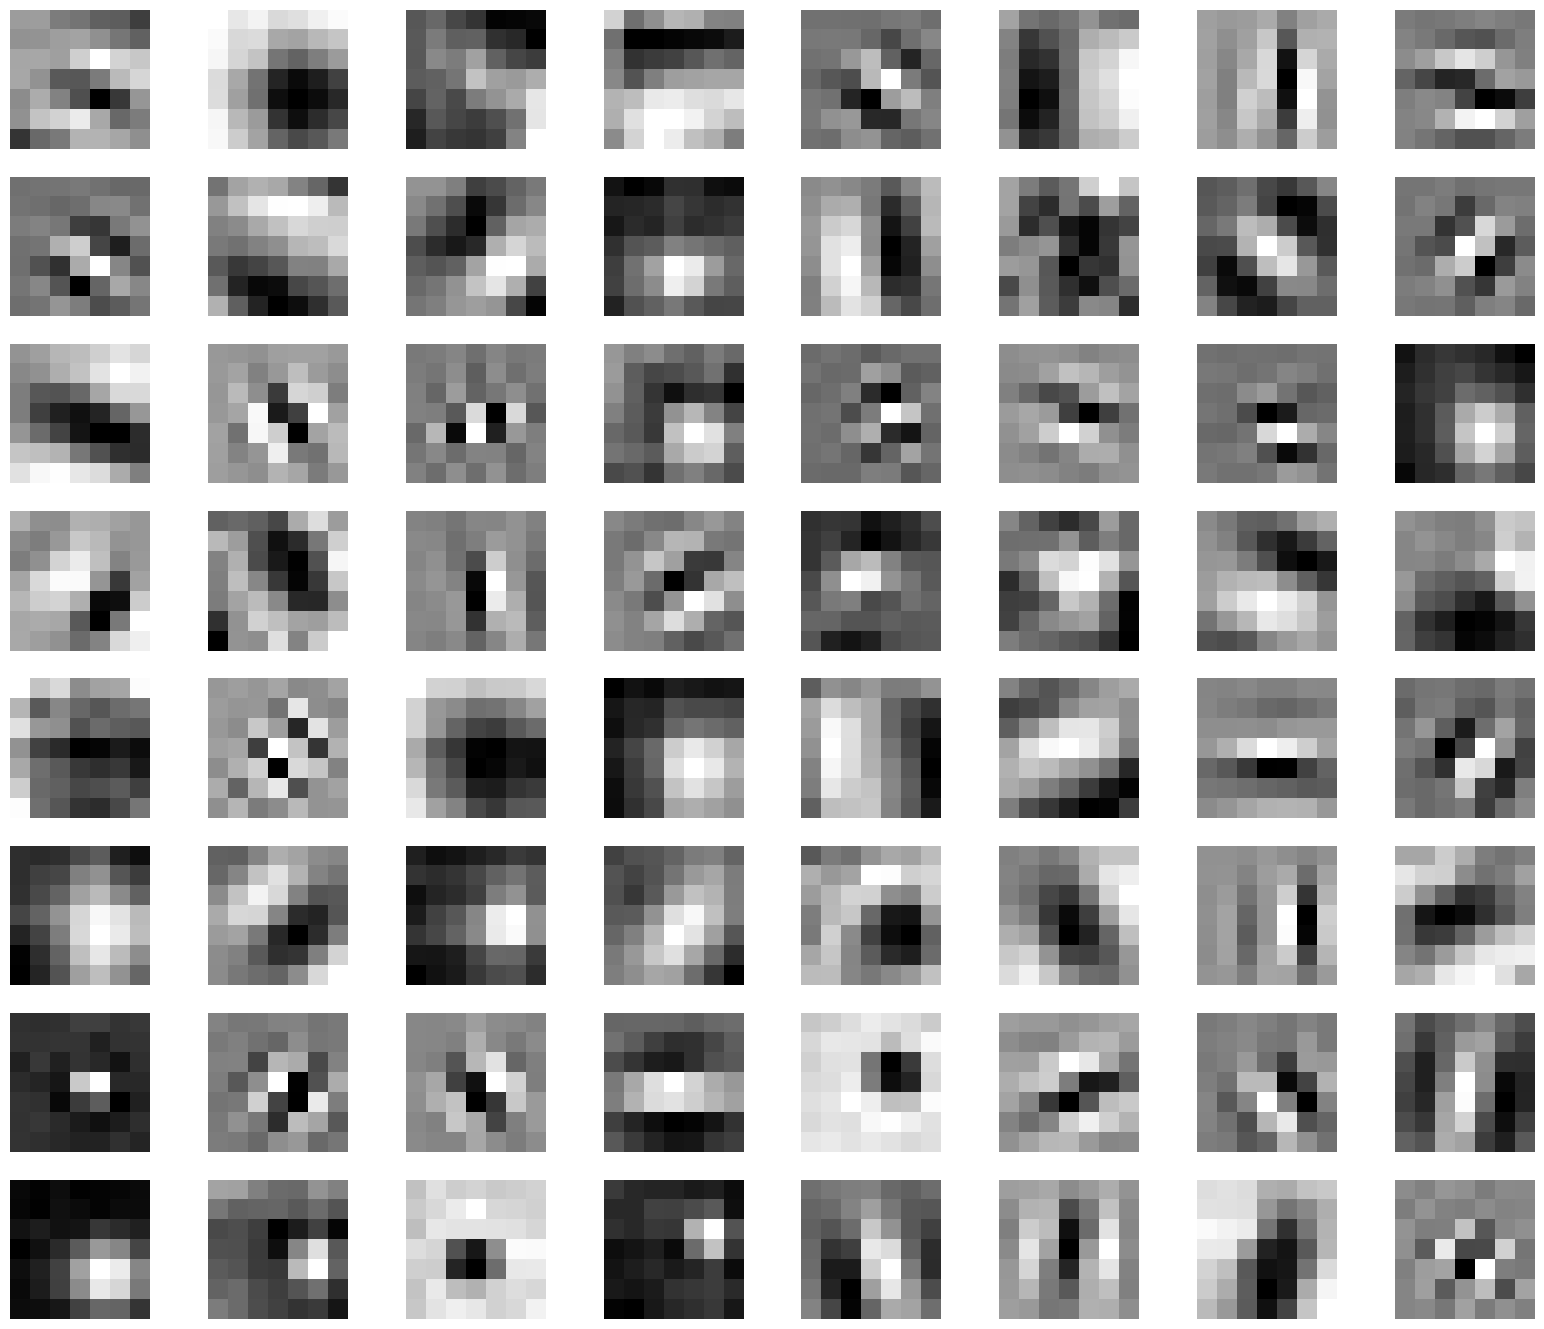

In [4]:
# visualize the filters of the first conv layer

plt.figure(figsize=(20, 17))
for i, filter in enumerate(model_weights[0]):
    # get the filter you want to visualise
    plt.subplot(8, 8, i+1) # the number of subplots should be as many as the filters we want to visualise
    plt.imshow(filter[0, :, :].detach(), cmap='gray')
    plt.axis('off')
    # plt.savefig('../outputs/filter.png') # Optional
plt.show()

We see that different kernels are focusing on different shapes, e.g. diagonal lines, squares etc. 

### The input image: loading and preparing for the model

Now that we are familiar with the model and the filters, we can see how more and more complex features are learnt in different layers. Let's start choosing an image and preparing it following the next steps:

* We first read the image by specifying the path to image.
* We define the image transformation which first converts the image to PIL format, resizes to a standard dimension of 512x512, changes the dtype to torch tensor, and normalises the image to the 0-1 range.
* Finally, we add the batch dimension to the existing image dimension 

*Note that DL models are trained in batches of images but in our case we have only one image so we add a batch dimension of size 1 - so there is only one image in this batch. Now the size of the image, instead of being [3, 512, 512], is [1, 3, 512, 512], indicating that there is only one image in the batch.*

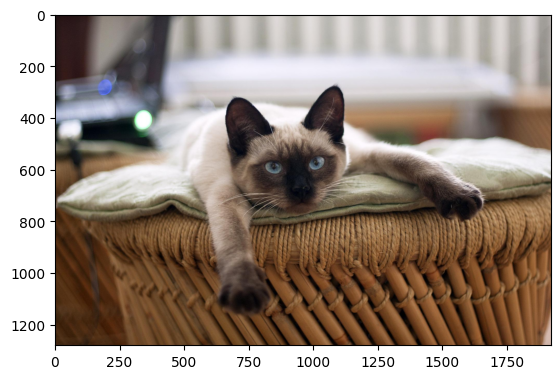

torch.Size([3, 512, 512])
torch.Size([1, 3, 512, 512])


In [5]:
# read and visualize an image
img = cv.imread("../data_and_models/images/cat.jpg") # Insert the path to image.
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()
# define the transforms (here we are using the ImageNet transformations)
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
img = np.array(img)
# apply the transforms
img = transform(img)
print(img.size())
# unsqueeze to add a batch dimension
img = img.unsqueeze(0)
print(img.size())

### Feature Maps of the Convolutional Layers

Visualizing the feature maps of the image after passing through the convolutional layers of the ResNet-50 model consists of two steps:

  * Passing the image through each convolutional layer and saving each layer’s output.
  * Visualizing the feature map blocks of each layer.

We will first give the image as an input to the first convolutional layer. After that, we will use a for loop to pass the last layer’s outputs to the next layer, until we reach the last convolutional layer.

In [6]:
# pass the image through first layer
results = [conv_layers[0] (img)]
for i in range(1, len(conv_layers)):
    # pass the result from the last layer to the next layer
    results.append(conv_layers[i](results[-1]))

### Visualizing the Feature Maps

The final layers (near the final fully connected layer) have many feature maps, in the range of 512 to 2048 _(again: look at the model architecture!)_. We will only visualize 64 feature maps from a layer at the beginning of the model, in the middle and in the final convolutional layer.

Size of layer 1 is torch.Size([64, 256, 256])
Feature maps from the first convolutional layer (layer [0, 24, 48]) of ResNet-50 model


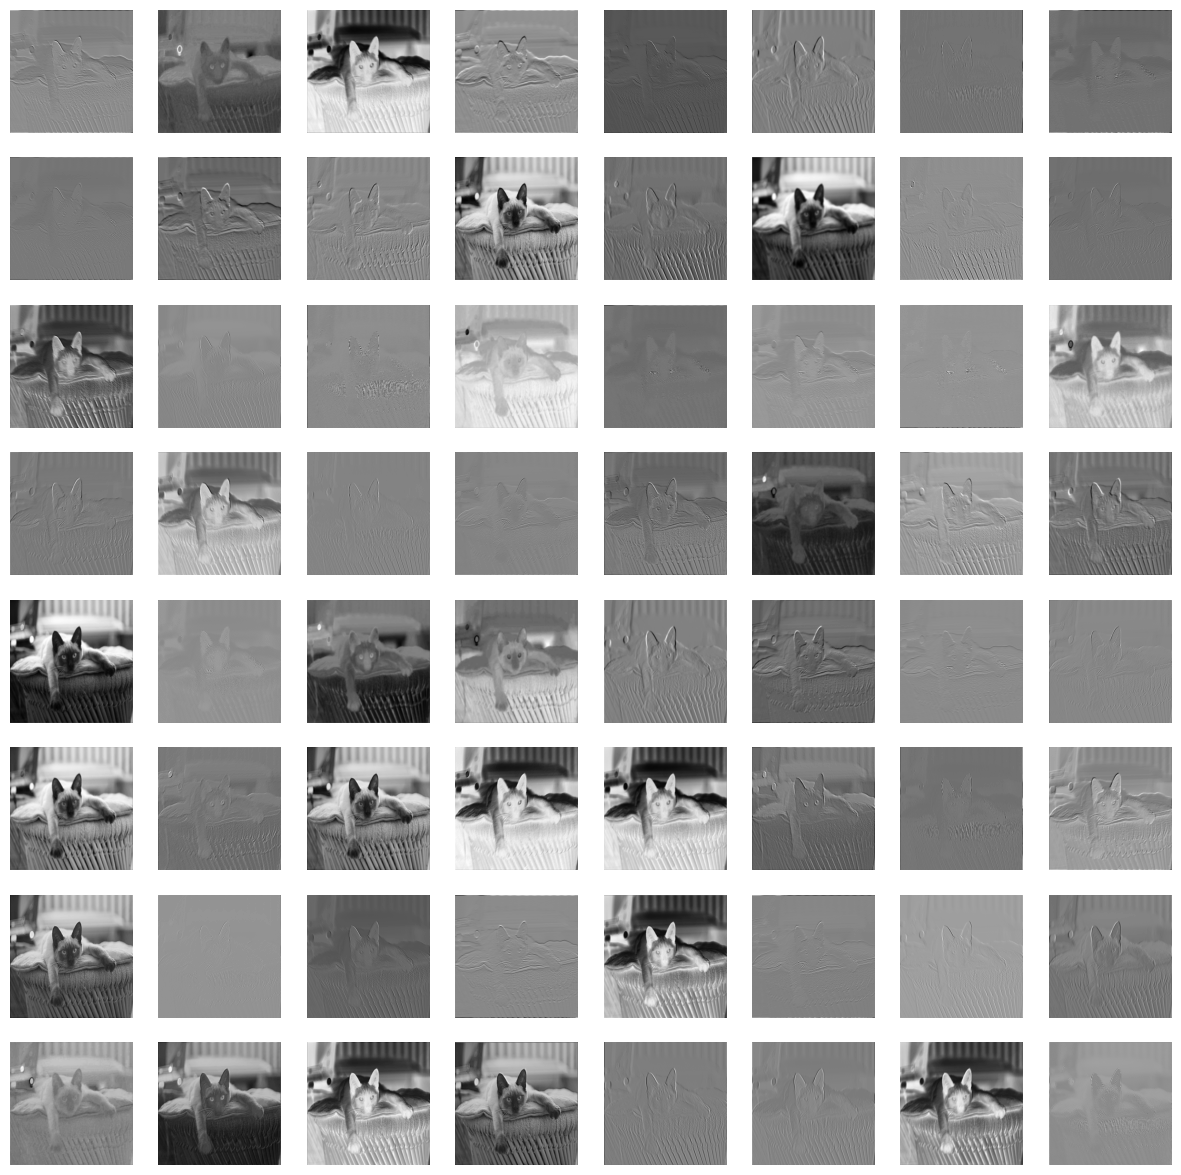

Size of layer 25 is torch.Size([1024, 64, 64])
Feature maps from the first convolutional layer (layer [0, 24, 48]) of ResNet-50 model


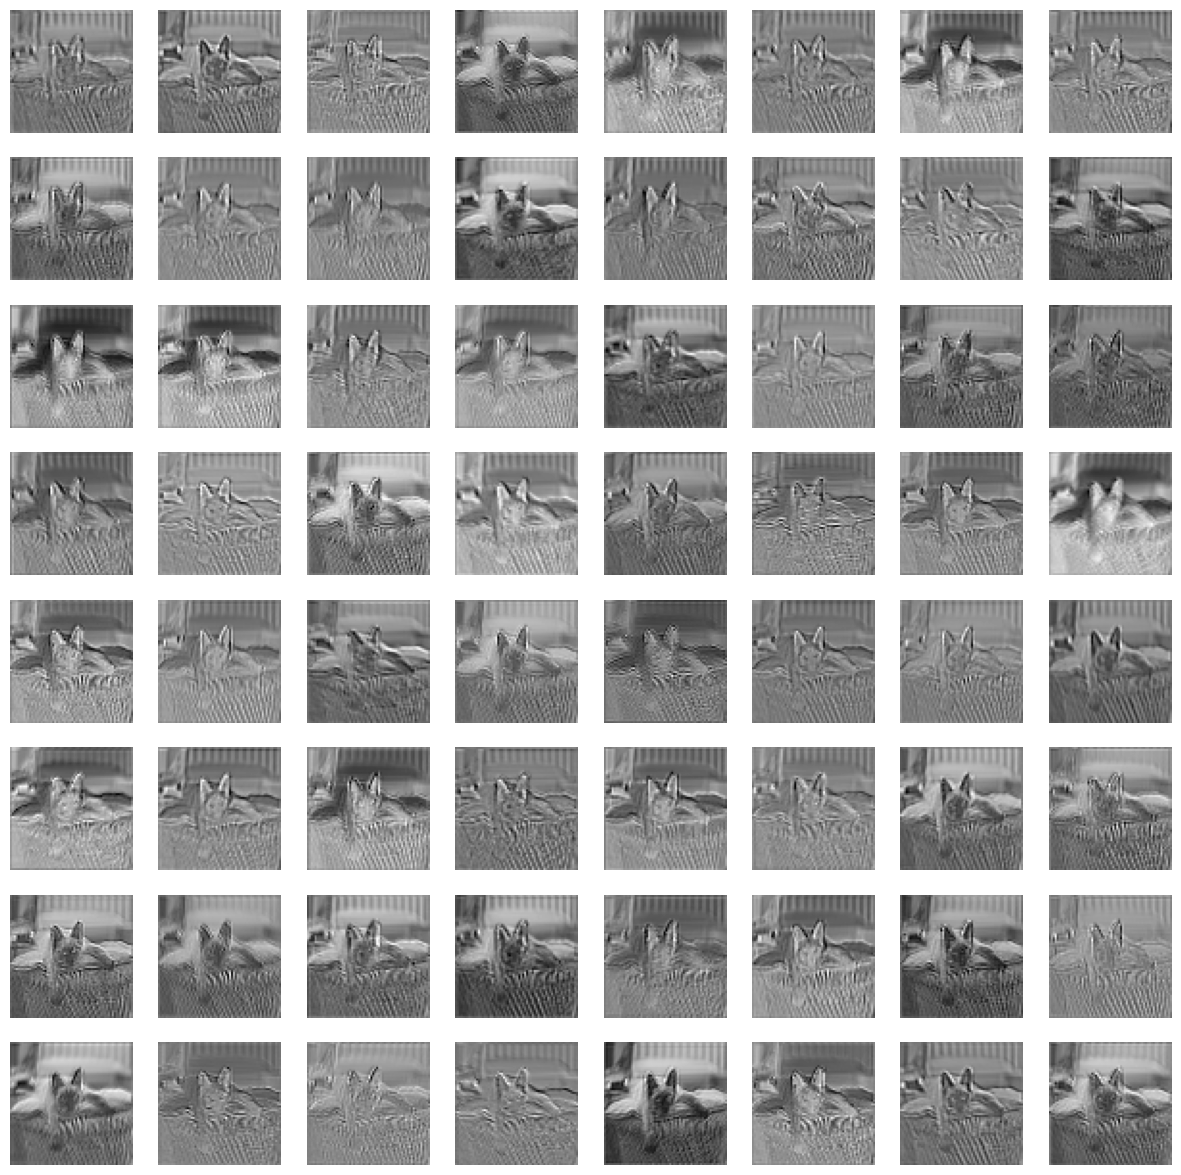

Size of layer 49 is torch.Size([2048, 32, 32])
Feature maps from the first convolutional layer (layer [0, 24, 48]) of ResNet-50 model


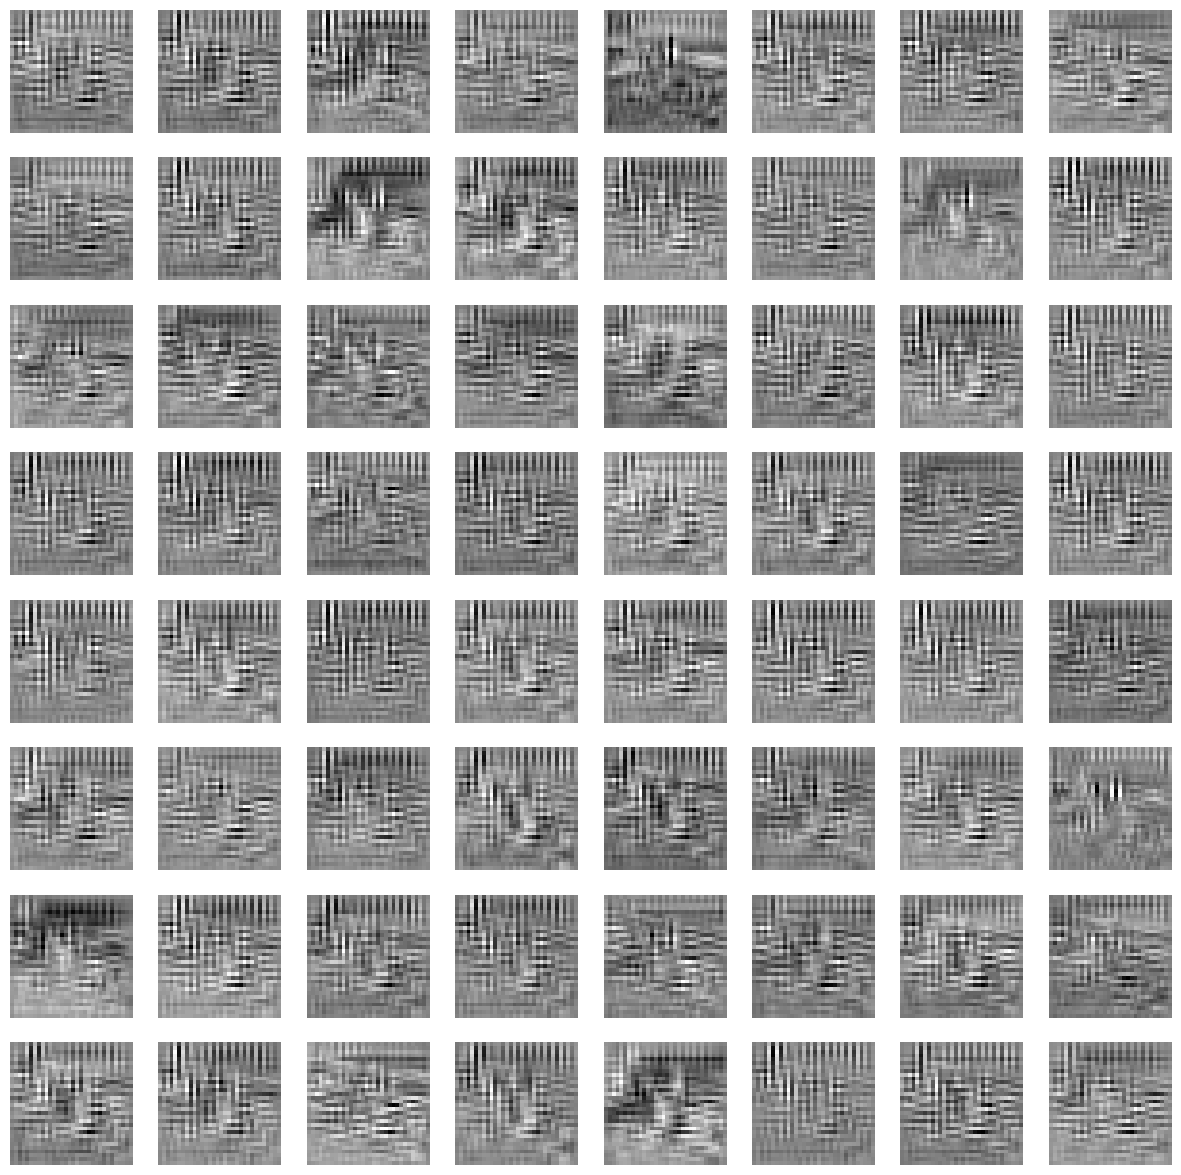

In [7]:
num_layer = [0,24,48]
for layer in num_layer:

    plt.figure(figsize=(15, 15))
    layer_viz = results[layer][0, :, :, :]
    layer_viz = layer_viz.data
    print(f'Size of layer {layer+1} is {layer_viz.size()}')
    print(f'Feature maps from the first convolutional layer (layer {num_layer}) of ResNet-50 model')
    for i, filter in enumerate(layer_viz):
        if i == 64: # we will visualize only 8x8 blocks from each layer
            break
        plt.subplot(8, 8, i + 1)
        plt.imshow(filter, cmap='gray')
        plt.axis("off")
    plt.show()
    plt.close()

### Discussion

* What do you notice when looking at the feature maps at the beginning, middle and end of the model?

* We only plotted a very small subset of the feature maps for one specific image! How much work would it be to go through all the feature maps and kernels to understand why a model makes a certain prediction?

## Optional

1. Play around with plotting pretrained filters in different layers and get a high level understanding of the region each filter concentrates on in an image as you move up the convolutional layers.

2. Note that in the feature visualisation of the first layer we are only looking at a third of the features as we have size 3 in dimension 1. How do the other features look like? 

3. Similarly, feel free to explore the feature maps at different layers and try to understand the evolution of feature maps and depth of the image in recognizing features that are important for classification.

4. Think about using a non trained network, that has no pretrained weights and pass the image through the network. Would you find any difference?

## References 

This tutorial was based on:  https://debuggercafe.com/visualizing-filters-and-feature-maps-in-convolutional-neural-networks-using-pytorch/

Theoretical points were taken from: https://christophm.github.io/interpretable-ml-book/neural-networks.html